#### Initialization

In [135]:
#pip install scipy

In [136]:
import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [137]:
class ftxt:
    """
    Provides strings for coloring/formatting text in the terminal.

    Colors: RED, GREEN, BLUE, YELLOW, PURPLE, CYAN.
        other Attributes:
            END (str): end the string with this to end text formatting
            BOLD (str): for writing bold text
            UNDERLINE (str): for writing underlined text        
    """

    RED = '\033[91m'
    GREEN = '\033[92m'
    BLUE = '\033[94m'
    YELLOW = '\033[93m'
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    END = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [138]:
ids_A = ["A8", "A10", "A11", "A12", "A14", "A15", "A16", "A17", "A18", "A19", "A20", "A21", "A22", "A23", "A24"]
ids_B = ["B4", "B5", "B6", "B7", "B9", "B11", "B12", "B13", "B14", "B15", "B16", "B17", "B18", "B19", "B20"]

Read experiment csv files into dictionarys

In [139]:
a_sample_dict, b_sample_dict, a_result_dict, b_result_dict = {}, {}, {}, {}
tmp = []

for id in ids_A:
    for i in range(125):
        tmp.append(pd.read_csv(fr"C:\Users\kevin\Desktop\ExperimentResults\Group_A\userID_{id}\SampledMetrics\trialIteration_{i}_samples.csv", sep=";"))
        #tmp[i].dropna(axis='columns')
    a_sample_dict[id] = tmp
    tmp = []
    
    #fixing broken first row in results 
    result_path = fr'C:\Users\kevin\Desktop\ExperimentResults\Group_A\userID_{id}'
    with open(fr"{result_path}\Result.csv", 'rt') as inp, open(fr"{result_path}\Result_edit.csv", 'wt') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            if row != ['sep=;']:
                writer.writerow(row)

    a_result_dict[id] = pd.read_csv(fr"{result_path}\Result_edit.csv", sep=";")
    # dropping irrelevant columns
    # a_result_dict[id].drop('TrialIteration', axis=1, inplace=True) # might be interesting, when sorting the columns after trialID
    a_result_dict[id].dropna(axis='columns', inplace=True)
    #a_result_dict[id] = a_result_dict[id].sort_values(by=['trialID'])
    a_result_dict[id]['trialID'] = pd.Series(a_result_dict[id]['trialID'], dtype="string").str.zfill(4)

for id in ids_B:
    for i in range(125):
        tmp.append(pd.read_csv(fr"C:\Users\kevin\Desktop\ExperimentResults\Group_B\userID_{id}\SampledMetrics\trialIteration_{i}_samples.csv", sep=";"))
        tmp[i].dropna(axis='columns')
        tmp[i].drop(columns=['g_r', 'injected_rotations', 'additional_virtual_rotation_accumulation',
                          'virtual_position', 'virtual_direction', 'virtual_euler', 'virtual_rotation'],
                    inplace=True)
    b_sample_dict[id] = tmp
    tmp = []

    #fixing broken first row in results 
    result_path = fr'C:\Users\kevin\Desktop\ExperimentResults\Group_B\userID_{id}'
    with open(fr"{result_path}\Result.csv", 'rt') as inp, open(fr"{result_path}\Result_edit.csv", 'wt') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            if row != ['sep=;']:
                writer.writerow(row)#
                
    b_result_dict[id] = pd.read_csv(fr"{result_path}\Result_edit.csv", sep=";")
    # dropping irrelevant columns
    b_result_dict[id].drop(columns=['min_g_r', 'max_g_r', 'g_r_average', 'sum_injected_rotation_g_r(IN DEGREES)', 'injected_rotation_average',
                                    'real_dir_at_virt_yaw', 'virt_dir_at_virt_yaw', 'max_yaw_virt', 'real_pos_at_virt_yaw', 'virt_pos_at_virt_yaw',
                                    'real_euler_at_real_yaw','virt_euler_at_real_yaw', 'real_euler_at_virt_yaw', 'virt_euler_at_virt_yaw',
                                    'real_rot_at_real_yaw',	'virt_rot_at_real_yaw', 'real_rot_at_virt_yaw' ,'virt_rot_at_virt_yaw'],
                           inplace=True)
    # b_result_dict[id].drop('TrialIteration', axis=1, inplace=True)  # might be interesting, when sorting the columns after trialID
    b_result_dict[id].dropna(axis='columns', inplace=True)
    #b_result_dict[id] = b_result_dict[id].sort_values(by=['trialID'])
    b_result_dict[id]['trialID'] = pd.Series(b_result_dict[id]['trialID'], dtype="string").str.zfill(4)

#a_result_dict['A10']
#b_result_dict['B4']
#a_sample_dict['A10'][25]
#a_result_dict['A10'].loc[:, 'min_g_r':'injected_rotation_average']

read questionnaire csv and concat to result csv

In [140]:
questionnaire_results = pd.read_csv(fr'C:\Users\kevin\Desktop\ExperimentResults\VR Ausweichstudie Fragebogen.csv')
questionnaire_results.drop('Bitte geben Sie an, ob Sie die Datenschutz- und Einverständniserklärung gelesen haben und fragen Sie den Versuchsleiter, falls Ihnen diese nicht vorgelegt wurde, diese durchzusehen und zu unterzeichnen.', axis=1, inplace=True)
questionnaire_results['ID Nummer'] = questionnaire_results['ID Nummer'].str.upper()
# renaming IPQ columns:                 # general "sense of being there"
questionnaire_results.rename(columns={'In der computererzeugten Welt hatte ich den Eindruck, dort gewesen zu sein... ': 'G1',
                                        # Spatial Presence
                                      'Ich hatte das Gefühl, daß die virtuelle Umgebung hinter mir weitergeht.': 'SP1',
                                      'Ich hatte das Gefühl, nur Bilder zu sehen. ': 'SP2',
                                      'Ich hatte nicht das Gefühl, in dem virtuellen Raum zu sein': "SP3",
                                      'Ich hatte das Gefühl, in dem virtuellen Raum zu handeln statt etwas von außen zu bedienen.': 'SP4',
                                      'Ich fühlte mich im virtuellen Raum anwesend. ': 'SP5',
                                        # Involvement 
                                      'Wie bewusst war Ihnen die reale Welt, während Sie sich durch die virtuelle Welt bewegten (z.B. Geräusche, Raumtemperatur, andere Personen etc.)? ':'INV1',
                                      'Meine reale Umgebung war mir nicht mehr bewusst.': 'INV2',
                                      'Ich achtete noch auf die reale Umgebung. ': 'INV3',
                                      'Meine Aufmerksamkeit war von der virtuellen Welt völlig in Bann gezogen. ':'INV4',
                                        # Experienced Realism
                                      'Wie real erschien Ihnen die virtuelle Umgebung? ': 'REAL1',
                                      'Wie sehr glich Ihr Erleben der virtuellen Umgebung dem Erleben einer realen Umgebung? ': "REAL2",
                                      'Wie real erschien Ihnen die virtuelle Welt? ': 'REAL3',
                                      'Die virtuelle Welt erschien mir wirklicher als die reale Welt. ': 'REAL4',                                      
                                      }, inplace=True)
questionnaire_results['VRSQ-Score'] = [None] * len(questionnaire_results)
questionnaire_results['SP-Score'] = [None] * len(questionnaire_results)
questionnaire_results['INV-Score'] = [None] * len(questionnaire_results)
questionnaire_results['REAL-Score'] = [None] * len(questionnaire_results)

questionnaire_dict = {}
for i in range(len(questionnaire_results)):
        questionnaire_dict[questionnaire_results.loc[i]['ID Nummer']] = questionnaire_results.loc[i]

#questionnaire_results
questionnaire_dict['B7']

Zeitstempel                                                                                                                             2022/12/27 8:09:30 PM MEZ
ID Nummer                                                                                                                                                      B7
Allgemeines Unwohlsein                                                                                                                                          1
Ermüdung                                                                                                                                                        3
Kopfschmerzen                                                                                                                                                   2
                                                                                                                                                  ...            
In welchem Ausmaß spielen Si

***
### Prepare Data

In [141]:
trial_id_list = []         # list of all trial IDs
no_form_ids = set([])      # list of all trial IDs without form
no_size_ids = set([])      # list of all trial IDs without size
no_speed_ids = set([])     # list of all trial IDs without speed
no_angle_ids = set([])     # list of all trial IDs without angle

for i in range(len(a_result_dict['A10'])):
    trial_id = a_result_dict['A10'].iloc[i]['trialID']
    trial_id_list.append(trial_id)
    no_form_ids.add(trial_id[:0]+ trial_id[1:])
    no_size_ids.add(trial_id[:1] + trial_id[2:])
    no_speed_ids.add(trial_id[:2] + trial_id[3:])
    no_angle_ids.add(trial_id[:3])

trial_id = '1234'
slice = trial_id[:1]+ trial_id[2:]
print(slice)

134


In [142]:
class variable:
    name:str
    conditions:list[any]
    id_position:int
    sliced_id_list:list[int]

    def __init__(self, name:str, conditions:list[any], id_position:int, sliced_id_list:list[int]):
        self.name = name
        self.conditions = conditions
        self.id_position = id_position
        self.sliced_id_list = sliced_id_list

    def slice_trial_id(self, trial_id:str):
        sliced_id = trial_id[:self.id_position]+ trial_id[self.id_position+1:]
        return sliced_id


form_var = variable('form', ['Sphere', 'Cylinder', 'Car'], 0, no_form_ids)
size_var = variable('size', [0.3, 0.8], 1, no_size_ids)
speed_var = variable('speed', [18, 24, 30], 2, no_speed_ids)
angle_var = variable('angle', [40, 27, 13, 0, -13, -27, -40], 3, no_angle_ids)

len(size_var.sliced_id_list)

63

In [143]:
def get_grouped_samples_for_key_by_variable(variable: variable, group_a_key:str, group_b_key=''):
    if group_b_key == '':
        group_b_key = group_a_key

    a_conditions = []
    b_conditions = []

    for condition in variable.conditions:
        a_samples = {}
        b_samples = {}

        for user_id in a_result_dict:
            condition_samples = a_result_dict[user_id].loc[a_result_dict[user_id][variable.name] == condition]

            for trial_id in condition_samples['trialID']:
                samples_by_trial = condition_samples.loc[condition_samples['trialID'] == trial_id][group_a_key].values[0]
                try:
                    a_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
                except KeyError:
                    a_samples[f'{variable.slice_trial_id(trial_id)}'] = []
                    a_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
        
        a_conditions.append(a_samples)
        
        
        for user_id in b_result_dict:
            condition_samples = b_result_dict[user_id].loc[b_result_dict[user_id][variable.name] == condition]

            for trial_id in condition_samples['trialID']:
                samples_by_trial = condition_samples.loc[condition_samples['trialID'] == trial_id][group_b_key].values[0]
                try:
                    b_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
                except KeyError:
                    b_samples[f'{variable.slice_trial_id(trial_id)}'] = []
                    b_samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)

        b_conditions.append(b_samples)
    
    return a_conditions, b_conditions


def get_samples_for_key_by_variable(group:str, variable: variable, key:str):
    if group == 'A':
        result_dict = a_result_dict
    elif group == 'B':
        result_dict = b_result_dict
    else:
        print('Error: group must be A or B')
        return

    conditions = []

    for condition in variable.conditions:
        samples = {}

        for user_id in result_dict:
            condition_samples = result_dict[user_id].loc[result_dict[user_id][variable.name] == condition]

            for trial_id in condition_samples['trialID']:
                samples_by_trial = condition_samples.loc[condition_samples['trialID'] == trial_id][key].values[0]
                try:
                    samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
                except KeyError:
                    samples[f'{variable.slice_trial_id(trial_id)}'] = []
                    samples[f'{variable.slice_trial_id(trial_id)}'].append(samples_by_trial)
        
        conditions.append(samples)
    
    return conditions

In [144]:
same = []
other = []
# check if the greatest max_yaw_virt has the same trialID as the greatest max_yaw_real for a given user_id
print('IDs and Values for Maxima:')

for id in a_result_dict:
    #for i in range(len(a_result_dict[id])):
    max_id_r = a_result_dict[id].loc[:,'max_yaw_real'].idxmax()
    min_id_r = a_result_dict[id].loc[:,'max_yaw_real'].idxmin()
    max_id_v = a_result_dict[id].loc[:,'max_yaw_virt'].idxmax()
    min_id_v = a_result_dict[id].loc[:,'max_yaw_virt'].idxmin()
    max_id_rot = a_result_dict[id].loc[:,'sum_injected_rotation_g_r(IN DEGREES)'].idxmax()
    if max_id_r == max_id_v:
        same.append([id, a_result_dict[id].iloc[max_id_r]["trialID"], a_result_dict[id].iloc[max_id_r]["max_yaw_real"], a_result_dict[id].iloc[max_id_r]["max_yaw_virt"]])
    else:
        other.append([id, 'real max:', a_result_dict[id].iloc[max_id_r]["trialID"], a_result_dict[id].iloc[max_id_r]["max_yaw_real"], a_result_dict[id].iloc[max_id_r]["max_yaw_virt"], 'virt max:', a_result_dict[id].iloc[max_id_v]["trialID"], a_result_dict[id].iloc[max_id_v]["max_yaw_real"], a_result_dict[id].iloc[max_id_v]["max_yaw_virt"]])

    r_max_id = a_result_dict[id].iloc[max_id_r]["trialID"]
    r_min_id = a_result_dict[id].iloc[min_id_r]["trialID"]
    v_max_id = a_result_dict[id].iloc[max_id_v]["trialID"]
    v_min_id = a_result_dict[id].iloc[min_id_v]["trialID"]
    rot_id = a_result_dict[id].iloc[max_id_rot]["trialID"]
    r_max_yaw = a_result_dict[id].iloc[max_id_r]["max_yaw_real"]
    r_min_yaw = a_result_dict[id].iloc[min_id_r]["max_yaw_real"]
    v_max_yaw = a_result_dict[id].iloc[max_id_v]["max_yaw_virt"]
    v_min_yaw = a_result_dict[id].iloc[min_id_v]["max_yaw_virt"]
    rot_val = a_result_dict[id].iloc[max_id_rot]["sum_injected_rotation_g_r(IN DEGREES)"]
    rot_v_yaw_val = a_result_dict[id].iloc[max_id_rot]["max_yaw_virt"]
    rot_r_yaw_val = a_result_dict[id].iloc[max_id_rot]["max_yaw_real"]

    print(f'R_Min: ID={r_min_id}, Value={r_min_yaw}')
    print(f'R_Max: ID={r_max_id}, Value={r_max_yaw}')
    print(f'__Rot: ID={rot_id}, Value={rot_val}, V_Yaw={rot_v_yaw_val}, R_Yaw={rot_r_yaw_val}')
    print()

print(f'The same: {len(same)}')
#print(f'The {other} ')#others: {other}')
#other
#print(results_where_key_is_max(a_result_dict, same[0][0], 'sum_injected_rotation_g_r(IN DEGREES)'))
#print(results_where_key_is_max(a_result_dict, same[0][0], 'max_yaw_virt'))
# print(1134/9)
# print('the maximum virtual yaw is always the same as the maximum real yaw')
#other

IDs and Values for Maxima:
R_Min: ID=1113, Value=-118.4477
R_Max: ID=0104, Value=148.1617
__Rot: ID=0104, Value=53.50099, V_Yaw=145.4198, R_Yaw=148.1617

R_Min: ID=1012, Value=-163.3654
R_Max: ID=2100, Value=160.7902
__Rot: ID=1005, Value=38.12798, V_Yaw=69.61877, R_Yaw=-76.98266

R_Min: ID=1122, Value=-145.6831
R_Max: ID=0001, Value=83.74387
__Rot: ID=2104, Value=54.91309, V_Yaw=-69.06892, R_Yaw=-71.50335

R_Min: ID=1105, Value=-182.865
R_Max: ID=1111, Value=175.3434
__Rot: ID=1105, Value=63.86304, V_Yaw=-135.7044, R_Yaw=-182.865

R_Min: ID=0105, Value=-152.671
R_Max: ID=1101, Value=209.5399
__Rot: ID=1006, Value=50.38511, V_Yaw=-80.27885, R_Yaw=-109.3973

R_Min: ID=1106, Value=-169.3482
R_Max: ID=2001, Value=60.25116
__Rot: ID=0106, Value=47.82547, V_Yaw=-115.3695, R_Yaw=-120.7049

R_Min: ID=1115, Value=-158.1191
R_Max: ID=1020, Value=219.0554
__Rot: ID=1101, Value=49.96778, V_Yaw=133.0212, R_Yaw=139.1646

R_Min: ID=1006, Value=-169.4794
R_Max: ID=1013, Value=213.1097
__Rot: ID=2002,

#### Max yaw by trial for each group

In [145]:
a_yaws_by_trial = {}    # maximum accumulated virtual yaw per trial in grop A
b_yaws_by_trial = {}    # maximum accumulated real yaw per trial in grop B

for trial_id in trial_id_list:
    a_yaws_by_trial[f'{trial_id}'] = []
    b_yaws_by_trial[f'{trial_id}'] = []
    
    for user_id in a_result_dict:
        a_yaws_by_trial[f'{trial_id}'].append(a_result_dict[user_id].loc[a_result_dict[user_id]['trialID'] == trial_id]['max_yaw_virt'].values[0])
        #a_yaws_by_trial[f'{trial_id}'].append(abs(a_result_dict[user_id].loc[a_result_dict[user_id]['trialID'] == trial_id]['max_yaw_virt'].values[0]))

    for user_id in b_result_dict:
        b_yaws_by_trial[f'{trial_id}'].append(b_result_dict[user_id].loc[b_result_dict[user_id]['trialID'] == trial_id]['max_yaw_real'].values[0])
        #b_yaws_by_trial[f'{trial_id}'].append(abs(b_result_dict[user_id].loc[b_result_dict[user_id]['trialID'] == trial_id]['max_yaw_real'].values[0]))

#### Max yaws by size and trial

In [146]:
a_small_sized_yaws_by_trial = {}    # yaw per trial for small sized objects for Group A
b_small_sized_yaws_by_trial = {}    # yaw per trial for small sized objects for Group B
a_big_sized_yaws_by_trial = {}    # yaw per trial for big sized objects for group A
b_big_sized_yaws_by_trial = {}    # yaw per trial for big sized objects for group B
small_sized_trial_ids = []    # trial IDs for all small sized objects
big_sized_trial_ids = []    # trial IDs for all big sized objects
small_sized_yaws = []
big_sized_jaws = []

for user_id in a_result_dict:
    small_sizes = a_result_dict[user_id].loc[a_result_dict[user_id]['size'] == 0.3]

    for trial_id in small_sizes['trialID']:
        yaws_by_trial = small_sizes.loc[small_sizes['trialID'] == trial_id]['max_yaw_virt'].values[0]
        try:
            a_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            a_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            a_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        small_sized_yaws.append(yaws_by_trial)

for user_id in b_result_dict:
    small_sizes = b_result_dict[user_id].loc[b_result_dict[user_id]['size'] == 0.3]

    for trial_id in small_sizes['trialID']:
        yaws_by_trial = small_sizes.loc[small_sizes['trialID'] == trial_id]['max_yaw_real'].values[0]
        try:
            b_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            b_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            b_small_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        small_sized_yaws.append(yaws_by_trial)

for user_id_a in a_result_dict:
    big_sizes = a_result_dict[user_id_a].loc[a_result_dict[user_id_a]['size'] == 0.8]

    for trial_id in big_sizes['trialID']:
        big_sized_trial_ids.append(trial_id)
        yaws_by_trial = big_sizes.loc[big_sizes['trialID'] == trial_id]['max_yaw_virt'].values[0]
        try:
            a_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            a_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            a_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        big_sized_jaws.append(f'{trial_id}')

for user_id_b in b_result_dict:
    big_sizes = b_result_dict[user_id_b].loc[b_result_dict[user_id_b]['size'] == 0.8]

    for trial_id in big_sizes['trialID']:
        yaws_by_trial = big_sizes.loc[big_sizes['trialID'] == trial_id]['max_yaw_real'].values[0]
        try:
            b_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        except KeyError:
            b_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'] = []
            b_big_sized_yaws_by_trial[f'{trial_id[:1] + trial_id[2:]}'].append(yaws_by_trial)
        big_sized_jaws.append(yaws_by_trial)


a_size_samples, b_size_samples = get_grouped_samples_for_key_by_variable(size_var, 'max_yaw_virt', 'max_yaw_real')

for trial_id in a_size_samples[0]:
    if a_big_sized_yaws_by_trial[trial_id] != a_size_samples[1][trial_id]:
        print(a_big_sized_yaws_by_trial[trial_id])
        print(a_size_samples[1][trial_id])

print(a_big_sized_yaws_by_trial['125'])
print(a_size_samples[1]['125'])
#print(len(big_sized_jaws))

[79.74974, -57.33629, -36.1325, -92.31796, 182.2314, -13.13463, -31.32183, -17.96552, -27.32403, -45.91121, 25.14571, -37.03136, 66.42007, -51.38204, -102.1654]
[79.74974, -57.33629, -36.1325, -92.31796, 182.2314, -13.13463, -31.32183, -17.96552, -27.32403, -45.91121, 25.14571, -37.03136, 66.42007, -51.38204, -102.1654]


***
### Significance tests

code taken from: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html </br>
see also: https://stackoverflow.com/questions/12838993/scipy-normaltest-how-is-it-used </br>
see also: https://www.pythonfordatascience.org/independent-samples-t-test-python/ </br>

In [173]:
def independent_test(a, b, alpha=0.05, print_results=False):
    a_series = pd.Series(a)
    b_series = pd.Series(b)
    #both = pd.Series(a + b)

    hypothesis = True
    equal_var = True

    _, p_shapiro_a = stats.shapiro(a)                                     # ??? muss man die samples einzeln oder zusammen auf Normalverteilung testen ???
    _, p_shapiro_b = stats.shapiro(b)                                     # ??? muss man die samples einzeln oder zusammen auf Normalverteilung testen ???
    #_, p_normal = stats.normaltest(both)
    if p_shapiro_a > alpha and p_shapiro_b > alpha:
        if print_results:
            print(f'Shapiro-Wilk: The samples {ftxt.GREEN}*ARE*{ftxt.END} normally distributed: p_a = {p_shapiro_a}; p_b = {p_shapiro_b}')
    else:
        if print_results:
            if p_shapiro_a <= alpha:
                print(f'Shapiro-Wilk: The samples of a {ftxt.RED}*ARE NOT*{ftxt.END} normally distributed: p_a = {p_shapiro_a}')
            if p_shapiro_b <= alpha:
                print(f'Shapiro-Wilk: The samples of b {ftxt.RED}*ARE NOT*{ftxt.END} normally distributed: p_b = {p_shapiro_b}')

        # use Mann-Whitney U test for non-normal distribution
        _, p_mannwhitney = stats.mannwhitneyu(a_series, b_series)
        if p_mannwhitney > alpha:
            if print_results:
                print(f'{ftxt.YELLOW}MANN-WHITNEY:{ftxt.END} There *IS NO* significant difference between the two sample sets: p = {p_mannwhitney}')
        else:
            if print_results:
                print(f'{ftxt.YELLOW}MANN-WHITNEY:{ftxt.END} There *IS* a significant difference between the two sample sets: p = {p_mannwhitney}')
            hypothesis = False
        
        # early Mann-Whitney U test return
        return hypothesis, p_mannwhitney


    # equal variance
    _, p_levene = stats.levene(a_series, b_series, center= 'mean')
    if p_levene > alpha:
        if print_results:
            print(f'The samples {ftxt.GREEN}*HAVE*{ftxt.END} equal variances: p = {p_levene}')
    else:
        if print_results:
            print(f'The samples {ftxt.RED}*HAVE NO*{ftxt.END} equal variances: p = {p_levene}')
        equal_var = False
    

    # t-Test
    _, p_ttest = stats.ttest_ind(a_series, b_series, equal_var=equal_var)

    if p_ttest > alpha:
        if print_results:
            print(f'There *IS NO* significant difference between the two sample sets: p = {p_ttest}')
    else:
        if print_results:
            print(f'There *IS* a significant difference between the two sample sets: p = {p_ttest}')
        hypothesis = False

    return hypothesis, p_ttest

In [148]:
def related_test(a, b, alpha=0.05, print_results=False):
    a_series = pd.Series(a)
    b_series = pd.Series(b)
    both = pd.Series(a + b)

    hypothesis = True
    equal_var = True

    _, p_shapiro = stats.shapiro(both)                                     # ??? muss man die samples einzeln oder zusammen auf Normalverteilung testen ???
    #_, p_normal = stats.normaltest(both)
    if p_shapiro > alpha:
        if print_results:
            print(f'Shapiro-Wilk: The samples *ARE* normally distributed: p = {p_shapiro}')
    else:
        if print_results:
            print(f'Shapiro-Wilk: The samples *ARE NOT* normally distributed: p = {p_shapiro}')

        # use Wilcoxon test for non-normal distribution
        _, p_wilcoxon = stats.wilcoxon(a_series, b_series)
        if p_wilcoxon > alpha:
            if print_results:
                print(f'Wilcoxon: There *IS NO* significant difference between the two sample sets: p = {p_wilcoxon}')
        else:
            if print_results:
                print(f'Wilcoxon: There *IS* a significant difference between the two sample sets: p = {p_wilcoxon}')
            hypothesis = False
        
        # early Wilcoxon test return
        return hypothesis, p_wilcoxon
    

    # t-Test
    _, p_ttest = stats.ttest_rel(a_series, b_series)

    if p_ttest > alpha:
        if print_results:
            print(f'There *IS NO* significant difference between the two sample sets: p = {p_ttest}')
    else:
        if print_results:
            print(f'There *IS* a significant difference between the two sample sets: p = {p_ttest}')
        hypothesis = False

    return hypothesis, p_ttest

In [191]:
def plot_test_data(a, b, title="", x_label_histogram="", show_probability_plot=True, show_histogram=True):
    a_series = pd.Series(a)
    b_series = pd.Series(b)
    both = pd.Series(a + b)

    #Normal Distribution
    if show_probability_plot:
        def show_prob_plot(samples):
            fig = plt.figure(figsize= (20, 10))
            ax = fig.add_subplot(111)
            res = stats.probplot(samples, plot=plt)
            plt.suptitle(title, fontsize= 20)
            ax.get_lines()[0].set_markerfacecolor('#b43092')
            ax.get_lines()[0].set_markeredgecolor('#b43092')
            ax.get_lines()[1].set_color('#ea5a00')
            plt.show()
        show_prob_plot(a)
        show_prob_plot(b)

    # equal variances
    if show_histogram:
        var_fig = plt.figure(figsize= (20, 10))
        ax = var_fig.add_subplot(111)
        plt.hist(a_series, color= '#ea5a00', label= "Group A", density= True, alpha=0.75)
        plt.hist(b_series, color= '#b43092', label= "Group B", density= True, alpha=0.75)
        plt.suptitle(title, fontsize= 20)
        plt.xlabel(x_label_histogram, fontsize= 16)
        plt.ylabel("Probability density", fontsize= 16)
        .01, .99, 'matplotlib', 
        plt.text(.01, .99, f"$\mu= {a_series.mean(): .1f}, \ \sigma= {a_series.std(): .1f}$", color='#ea5a00', ha='left', va='top', transform=ax.transAxes)
        plt.text(.01, .97, f"$\mu= {b_series.mean(): .1f}, \ \sigma= {b_series.std(): .1f}$", color='#b43092', ha='left', va='top', transform=ax.transAxes)
        var_fig.tight_layout()
        plt.show()

In [365]:
def boxplot(values, value_names=['A', 'B'], title='', xlabel='', ylabel='', showfliers=True):
    fig7, ax = plt.subplots()
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.yaxis.grid(True)
    medianprops = dict(linewidth=2, color='#c81e0f')
    flierprops={'marker': 'D', 'markersize': 8, 'markeredgecolor': '#b43092'}#, 'markerfacecolor': '#ebd0e5'}
    bplot = ax.boxplot(values, labels=value_names, patch_artist=True, medianprops=medianprops, flierprops=flierprops, showfliers=showfliers)

    for patch in bplot['boxes']:
        patch.set_facecolor('#fcdac2')

    plt.show()

def subboxplot(ax: plt.Axes, values, value_names=['A', 'B'], title:str ='', xlabel:str='', ylabel:str=''):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.yaxis.grid(True)
    medianprops = dict(linewidth=2, color='#c81e0f')
    flierprops={'marker': 'D', 'markersize': 8, 'markerfacecolor': '#ebd0e5', 'markeredgecolor': '#b43092'}
    bplot = ax.boxplot(values, labels=value_names, patch_artist=True, medianprops=medianprops, flierprops=flierprops)

    for patch in bplot['boxes']:
        patch.set_facecolor('#fcdac2')


***
### Hypothesisesesssss

#### H3: Die reelle Kopfrotation von Gruppe B ähnelt der virtuellen Kopfrotation von Gruppe A. 

In [150]:
print(f'H0: There are no significant differences in the REAL max yaw yalues of Group B and the VIRTUAL max yaw values of Group A for a specific trial.')
hypothesis_counter = 0
significant_trials = []

for trial_id in trial_id_list:
    a = pd.Series(a_yaws_by_trial[f'{trial_id}'])
    b = pd.Series(b_yaws_by_trial[f'{trial_id}'])

    #print(f'Trial {trial_id}:')
    hypothesis, _ = independent_test(a, b)#, print_results=True)
    #print()

    if hypothesis:
        hypothesis_counter += 1
    else:
        significant_trials.append(trial_id)
        #print(f'Trial {trial_id}:')
        #plot_test_data(a, b)        

# print(f'{(len(trial_id_list)-assumption_counter)/len(trial_id_list)*100} % of {len(trial_id_list)} trials can not be tested with the t-Test')
# print(f'The {len(false_assumption_trials)} untestable trials are: {false_assumption_trials}')
print(f'{hypothesis_counter/len(trial_id_list)*100} % of {len(trial_id_list)} tested trials show no significant difference between Group A and B')
print(f'The {len(significant_trials)} significant trials are: {significant_trials}')

H0: There are no significant differences in the REAL max yaw yalues of Group B and the VIRTUAL max yaw values of Group A for a specific trial.
94.44444444444444 % of 126 tested trials show no significant difference between Group A and B
The 7 significant trials are: ['1126', '1010', '1016', '2024', '1021', '0116', '0015']


#### H04: Größere Objekte rufen beim Ausweichen eine größere Kopfrotation hervor, als kleinere Objekte. 

96.82539682539682 % of 63 tested trials show no significant difference between size 0.3 and 0.8
The 2 significant trials are: ['203', '111']


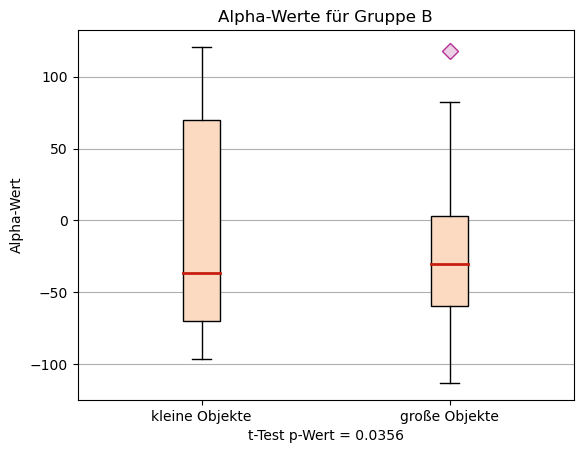

In [321]:
hypothesis_counter = 0
significant_trials = []

a_sizes, b_sizes = get_grouped_samples_for_key_by_variable(size_var, 'max_yaw_virt', 'max_yaw_real')

for id in no_size_ids:
    a = pd.Series(b_sizes[0][f'{id}'])
    b = pd.Series(b_sizes[1][f'{id}'])

    #print(f'Trial {id}:')
    hypothesis, p = independent_test(a, b)#, print_results=True)
    #print()

    if hypothesis:
        hypothesis_counter += 1
    else:
        significant_trials.append(id)
        # print(f'Trial {id}:')
        # plot_test_data(a, b)

# print(f'{(len(trial_id_list)-assumption_counter)/len(trial_id_list)*100} % of {len(trial_id_list)} trials can not be tested with the t-Test')
# print(f'The {len(false_assumption_trials)} untestable trials are: {false_assumption_trials}')
print(f'{hypothesis_counter/len(no_size_ids)*100} % of {len(no_size_ids)} tested trials show no significant difference between size 0.3 and 0.8')
print(f'The {len(significant_trials)} significant trials are: {significant_trials}')
a_sums = get_samples_for_key_by_variable('A', size_var, 'sum_injected_rotation_g_r(IN DEGREES)')
boxplot([list(b_sizes[0].values())[0], list(b_sizes[1].values())[0]], title='Alpha-Werte für Gruppe B', xlabel=f't-Test p-Wert = {p.round(4)}', ylabel='Alpha-Wert', value_names=['kleine Objekte', 'große Objekte'])


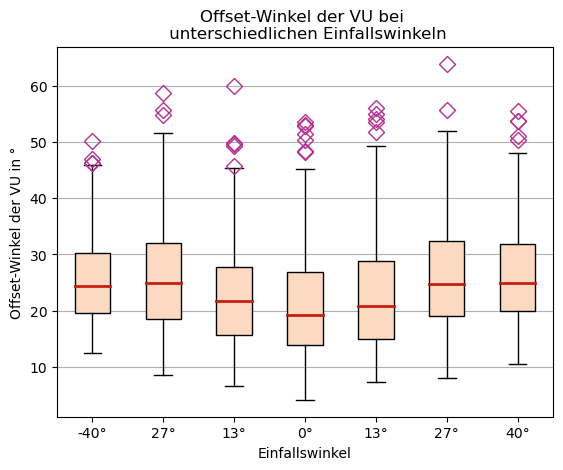

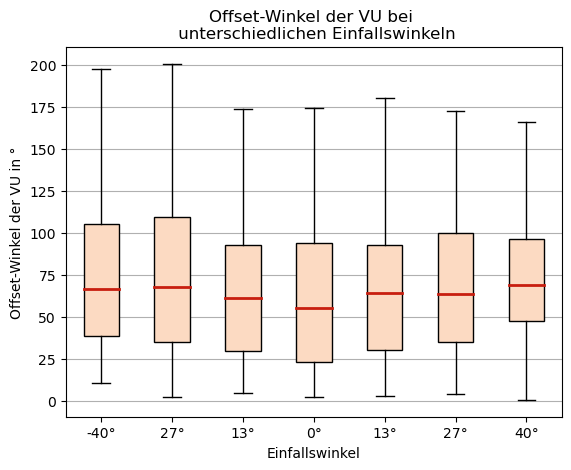

In [368]:
a_sums = get_samples_for_key_by_variable('A', angle_var, 'sum_injected_rotation_g_r(IN DEGREES)')
angle_values = {}
for i in range(len(a_sums)):
    angle_values[i] = []
    for values in list(a_sums[i].values()):
        for value in values:
            angle_values[i].append(value)
# print(len(angle_values))
# print(angle_values[0])
boxplot([angle_values[0], angle_values[1], angle_values[2], angle_values[3], angle_values[4], angle_values[5], angle_values[6]], title='Offset-Winkel der VU bei \n unterschiedlichen Einfallswinkeln', xlabel='Einfallswinkel', ylabel='Offset-Winkel der VU in °', value_names=['-40°', '27°', '13°', '0°', '13°', '27°', '40°'])

a_sums = get_samples_for_key_by_variable('B', angle_var, 'max_yaw_real')
angle_values = {}
for i in range(len(a_sums)):
    angle_values[i] = []
    for values in list(a_sums[i].values()):
        for value in values:
            angle_values[i].append(abs(value))
#print(len(angle_values[0]))
# print(angle_values[0])
boxplot([angle_values[0], angle_values[1], angle_values[2], angle_values[3], angle_values[4], angle_values[5], angle_values[6]],showfliers=False, title='Offset-Winkel der VU bei \n unterschiedlichen Einfallswinkeln', xlabel='Einfallswinkel', ylabel='Offset-Winkel der VU in °', value_names=['-40°', '27°', '13°', '0°', '13°', '27°', '40°'])

In [152]:
def test_group_differences(variable: variable, condition:int, group_a_key:str, group_b_key='', print_results=False, plot_data=False):
    if group_b_key == '':
        group_b_key = group_a_key

    hypothesis_counter = 0
    significant_trials = []

    a_conditions, b_conditions = get_grouped_samples_for_key_by_variable(variable, group_a_key, group_b_key)

    for id in variable.sliced_id_list:
        a = pd.Series(a_conditions[condition][f'{id}'])
        b = pd.Series(b_conditions[condition][f'{id}'])

        if print_results:
            print(f'Trial {id}:')
            hypothesis, _ = independent_test(a, b, print_results=True)
            print()
        else:
            hypothesis, _ = independent_test(a, b)

        if hypothesis:
            hypothesis_counter += 1
        else:
            significant_id = id[:variable.id_position] + '*' + id[variable.id_position:]
            significant_trials.append(significant_id)
        
        if plot_data:
            print(f'Trial {id}:')
            plot_test_data(a, b)

    print(f'{hypothesis_counter/len(variable.sliced_id_list)*100} % of {len(variable.sliced_id_list)} tested trials show no significant difference between group A and B.')
    print(f'The {len(significant_trials)} significant trials are: {significant_trials}')


def test_condition_differences(group:str, variable: variable, condition1:int, condition2:int, key:str, print_results=False, plot_data=False, except_var:variable=None, except_condition:int=None):
    hypothesis_counter = 0
    count = 0
    significant_trials = []

    if except_var != None:
        #print(f'excepting condition: {except_var.conditions[except_condition]}')
        if variable.id_position < except_var.id_position:
            except_id_pos = except_var.id_position - 1
        else:
            except_id_pos = except_var.id_position

    conditions = get_samples_for_key_by_variable(group, variable, key)

    for id in variable.sliced_id_list:
        if except_condition != None and int(id[except_id_pos]) == except_condition:
            continue
        count += 1

        a = pd.Series(conditions[condition1][f'{id}'])
        b = pd.Series(conditions[condition2][f'{id}'])

        if print_results:
            print(f'Trial {id}:')
            hypothesis, _ = independent_test(a, b, print_results=True)
            print()
        else:
            hypothesis, _ = independent_test(a, b)

        if hypothesis:
            hypothesis_counter += 1
        else:
            significant_id = id[:variable.id_position] + '*' + id[variable.id_position:]
            significant_trials.append(significant_id)
        
        if plot_data:
            print(f'Trial {id}:')
            plot_test_data(a, b)

    # print help variables
    con1 = variable.conditions[condition1]
    con2 = variable.conditions[condition2]

    print(f'{hypothesis_counter/count*100} % of {count} tested trials show no significant difference between {variable.name} conditions {con1} and {con2} in group {group}.')
    print(f'The {len(significant_trials)} significant trials are: {significant_trials}')


def test_group_differences_for_all_conditions(variable: variable, group_a_key:str, group_b_key='', print_results=False, plot_data=False):
    for i in range(len(variable.conditions)):
        test_group_differences(variable, i, group_a_key, group_b_key, print_results, plot_data)


def test_all_conditions_against(group:str, variable: variable, against_condition:int, key:str, print_results=False, plot_data=False, except_var:variable=None, except_condition:int=None):
    for i in range(len(variable.conditions)):
        if i == against_condition:
            continue
        test_condition_differences(group, variable, against_condition, i, key, print_results, plot_data, except_var, except_condition)


In [153]:
# test_group_differences_for_all_conditions(angle_var, 'max_yaw_real')
# test_group_differences_for_all_conditions(angle_var, 'max_yaw_virt', 'max_yaw_real')

ex_con = 2
test_all_conditions_against('B', angle_var, 0, 'max_yaw_real', except_var=speed_var, except_condition=ex_con)
print()
test_all_conditions_against('B', angle_var, 6, 'max_yaw_real', except_var=speed_var, except_condition=ex_con)
# print()
# test_all_conditions_against('A', angle_var, 0, 'max_yaw_virt')#, except_var=form_var, except_condition=ex_con)
# print()
# test_all_conditions_against('A', angle_var, 6, 'max_yaw_virt')#, except_var=form_var, except_condition=ex_con)


83.33333333333334 % of 12 tested trials show no significant difference between angle conditions 40 and 27 in group B.
The 2 significant trials are: ['011*', '101*']
100.0 % of 12 tested trials show no significant difference between angle conditions 40 and 13 in group B.
The 0 significant trials are: []
83.33333333333334 % of 12 tested trials show no significant difference between angle conditions 40 and 0 in group B.
The 2 significant trials are: ['011*', '211*']
50.0 % of 12 tested trials show no significant difference between angle conditions 40 and -13 in group B.
The 6 significant trials are: ['011*', '211*', '000*', '201*', '100*', '101*']
41.66666666666667 % of 12 tested trials show no significant difference between angle conditions 40 and -27 in group B.
The 7 significant trials are: ['011*', '001*', '211*', '000*', '201*', '210*', '101*']
58.333333333333336 % of 12 tested trials show no significant difference between angle conditions 40 and -40 in group B.
The 5 significant tri

In [154]:
# test_group_differences(form_var, 0, 'max_yaw_virt', 'max_yaw_real')
# test_group_differences(form_var, 1, 'max_yaw_virt', 'max_yaw_real')
# test_group_differences(form_var, 2, 'max_yaw_virt', 'max_yaw_real')

test_condition_differences('B', form_var, 0, 1, 'max_yaw_real')
test_condition_differences('B', form_var, 0, 2, 'max_yaw_real')
test_condition_differences('B', form_var, 1, 2, 'max_yaw_real')
print()
test_condition_differences('A', form_var, 0, 1, 'max_yaw_virt')
test_condition_differences('A', form_var, 0, 2, 'max_yaw_virt')
test_condition_differences('A', form_var, 1, 2, 'max_yaw_virt')

95.23809523809523 % of 42 tested trials show no significant difference between form conditions Sphere and Cylinder in group B.
The 2 significant trials are: ['*010', '*111']
95.23809523809523 % of 42 tested trials show no significant difference between form conditions Sphere and Car in group B.
The 2 significant trials are: ['*103', '*111']
100.0 % of 42 tested trials show no significant difference between form conditions Cylinder and Car in group B.
The 0 significant trials are: []

97.61904761904762 % of 42 tested trials show no significant difference between form conditions Sphere and Cylinder in group A.
The 1 significant trials are: ['*120']
95.23809523809523 % of 42 tested trials show no significant difference between form conditions Sphere and Car in group A.
The 2 significant trials are: ['*126', '*106']
97.61904761904762 % of 42 tested trials show no significant difference between form conditions Cylinder and Car in group A.
The 1 significant trials are: ['*025']


In [155]:
for angle_i in range(len(angle_var.conditions)):
    for angle_j in range(len(angle_var.conditions)):
        if angle_i != angle_j:
            test_condition_differences('A', angle_var, angle_i, angle_j, 'sum_injected_rotation_g_r(IN DEGREES)')
        

94.44444444444444 % of 18 tested trials show no significant difference between angle conditions 40 and 27 in group A.
The 1 significant trials are: ['112*']
88.88888888888889 % of 18 tested trials show no significant difference between angle conditions 40 and 13 in group A.
The 2 significant trials are: ['202*', '012*']
55.55555555555556 % of 18 tested trials show no significant difference between angle conditions 40 and 0 in group A.
The 8 significant trials are: ['001*', '112*', '212*', '201*', '210*', '002*', '200*', '012*']
83.33333333333334 % of 18 tested trials show no significant difference between angle conditions 40 and -13 in group A.
The 3 significant trials are: ['212*', '002*', '202*']
100.0 % of 18 tested trials show no significant difference between angle conditions 40 and -27 in group A.
The 0 significant trials are: []
100.0 % of 18 tested trials show no significant difference between angle conditions 40 and -40 in group A.
The 0 significant trials are: []
94.444444444

***
### Calculate Questionnaire Data

Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.07096214592456818; p_b = 0.751789391040802
The samples *HAVE* equal variances: p = 0.5706815930512352
There *IS NO* significant difference between the two sample sets: p = 0.5618066600082323


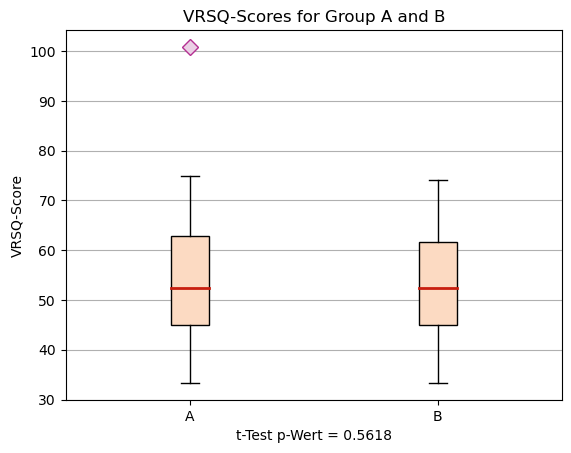

In [287]:
b_scores, a_scores = [], []

for user_key in questionnaire_dict:
    # if(user_key == 'A12'):
    #     continue
    user_answers = questionnaire_dict[user_key]
    a = user_answers['Allgemeines Unwohlsein'] + user_answers['Ermüdung'] + user_answers['Kopfschmerzen'] + user_answers['angestrengte Augen']
    b = user_answers['Schwierigkeiten scharf zu sehen'] + user_answers['Kopfdruck'] + user_answers['Verschwommenes Sehen'] + user_answers['Schwindel bei geschlossenen Augen'] + user_answers['Gleichgewichtsstörungen']
    c = a / 12 * 100
    d = b / 15 * 100
    user_score = (c + d) / 2
    questionnaire_dict[user_key]['VRSQ-Score'] = user_score
    #print('VRSQ Score for', user_answers['ID Nummer'], 'is', questionnaire_dict[user_key]['VRSQ-Score'])

    if 'A' in user_key:
        a_scores.append(user_score)
    elif 'B' in user_key:
        b_scores.append(user_score)

_, p = independent_test(a_scores, b_scores, print_results= True)
boxplot([a_scores, b_scores], title='VRSQ-Scores for Group A and B', xlabel=f't-Test p-Wert = {p.round(4)}', ylabel='VRSQ-Score')

#### IPQ Scores:

Genereal sense of being there:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.5790197253227234; p_b = 0.31636592745780945
The samples *HAVE* equal variances: p = 0.20412774932965308
There *IS NO* significant difference between the two sample sets: p = 0.479051781245022

Spatial Presence:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.23939655721187592; p_b = 0.39890605211257935
The samples *HAVE* equal variances: p = 0.17769364302686064
There *IS NO* significant difference between the two sample sets: p = 0.799826680855636

Involvement:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.09412603825330734; p_b = 0.5164908170700073
The samples *HAVE* equal variances: p = 0.894022537626751
There *IS NO* significant difference between the two sample sets: p = 0.8337160254982605

Realism:
Shapiro-Wilk: The samples *ARE* normally distributed: p_a = 0.7133517265319824; p_b = 0.39409011602401733
The samples *HAVE* equal variances: p = 0.0959700725978803

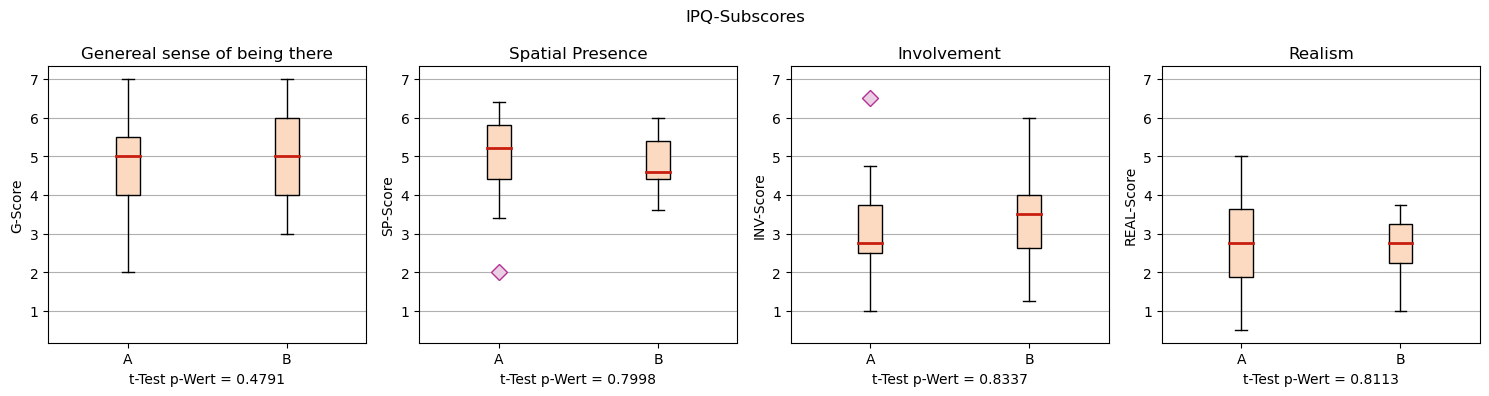

In [285]:
a_g, a_sp, a_inv, a_real = [], [], [], []
b_g, b_sp, b_inv, b_real = [], [], [], []
count_a, count_b = 0, 0

for key in questionnaire_dict:
    user_answers = questionnaire_dict[key]
    # calculate mean of each sub-score and invert SP2, INV3 and REAL1
    sp = (user_answers['SP1'] + (-1 * user_answers['SP2'] + 6) + user_answers['SP3'] + user_answers['SP4'] + user_answers['SP5']) / 5
    inv = (user_answers['INV1'] + user_answers['INV2'] + (-1 * user_answers['INV3'] + 6) + user_answers['INV4']) / 4
    real = ((-1 * user_answers['REAL1'] + 6) + user_answers['REAL2'] + user_answers['REAL3'] + user_answers['REAL4']) / 4

    questionnaire_dict[key]['SP-Score'] = sp
    questionnaire_dict[key]['INV-Score'] = inv
    questionnaire_dict[key]['REAL-Score'] = real

    # sum up scores of all keys containing A and B
    if 'A' in key:
        a_g.append(questionnaire_dict[key]['G1'])
        a_sp.append(sp)
        a_inv.append(inv)
        a_real.append(real)
    elif 'B' in key:
        b_g.append( questionnaire_dict[key]['G1'])
        b_sp.append(sp)
        b_inv.append(inv)
        b_real.append(real)

print('Genereal sense of being there:')
_, p_g = independent_test(a_g, b_g, print_results=True)
print()
print('Spatial Presence:')
_, p_sp = independent_test(a_sp, b_sp, print_results=True)
print()
print('Involvement:')
_, p_inv = independent_test(a_inv, b_inv, print_results=True)
print()
print('Realism:')
_, p_real = independent_test(a_real, b_real, print_results=True)

def plots_in_a_row():
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    subboxplot(axs[0], [a_g, b_g], title='Genereal sense of being there', ylabel='G-Score', xlabel=f't-Test p-Wert = {p_g.round(4)}')
    subboxplot(axs[1],[a_sp, b_sp], title='Spatial Presence', ylabel='SP-Score', xlabel=f't-Test p-Wert = {p_sp.round(4)}')
    subboxplot(axs[2],[a_inv, b_inv], title='Involvement', ylabel='INV-Score', xlabel=f't-Test p-Wert = {p_inv.round(4)}')
    subboxplot(axs[3],[a_real, b_real], title='Realism', ylabel='REAL-Score', xlabel=f't-Test p-Wert = {p_real.round(4)}')
    axs[1].sharey(axs[0])
    axs[2].sharey(axs[0])
    axs[3].sharey(axs[0])

    fig.suptitle('IPQ-Subscores')    
    fig.tight_layout()

    plt.show()

plots_in_a_row()

***
### how to reference Pandas Dateframes

reference Samples

In [158]:
user_id = "A10"
trial_iteration = 25
sample = 2
sample_key = "g_r"

# get the whole dataframe of a trial
a_sample_dict[user_id][trial_iteration]

# get sample list:
a_sample_dict[user_id][trial_iteration][sample_key]

# get all values from specific sample
a_sample_dict[user_id][trial_iteration].iloc[sample]

# get a specific value 
a_sample_dict[user_id][trial_iteration].iloc[sample][sample_key]

# print all sample key names
a_sample_dict[user_id][trial_iteration].columns

Index(['sampling_intervals', 'g_r', 'injected_rotations',
       'real_rotation_accumulation',
       'additional_virtual_rotation_accumulation', 'real_position',
       'virtual_position', 'real_direction', 'virtual_direction', 'real_euler',
       'virtual_euler', 'real_rotation', 'virtual_rotation',
       'relative_virt_position', 'Unnamed: 14'],
      dtype='object')

reference Results

In [159]:
user_id = "A10"
trial_iteration = 25
trial = 80
column = "sum_injected_rotation_g_r(IN DEGREES)"

# get the whole result dataframe of a trial
a_result_dict[user_id]
# get a column:
a_result_dict[user_id][column]
# get a row
a_result_dict[user_id].iloc[trial]
# get a specific value
a_result_dict[user_id].iloc[trial][column]
# print all column names
b_result_dict['B4'].columns

Index(['TrialIteration', 'EndState', 'experiment_start_time', 'trialID',
       'form', 'size', 'speed', 'angle', 'experiment_duration',
       'average_sampling_interval', 'sum_real_distance_travelled(IN METERS)',
       'max_distance_to_center', 'real_pos_at_max_dist',
       'virt_pos_at_max_dist', 'max_yaw_real', 'real_dir_at_real_yaw',
       'virt_dir_at_real_yaw', 'real_pos_at_real_yaw', 'virt_pos_at_real_yaw'],
      dtype='object')

split multidimensional samples with .split(",") like this:

In [160]:
x, y, z, w = a_result_dict[user_id].iloc[trial_iteration]['real_rot_at_real_yaw'].split(',')
print(x)
print(y)
print(z)
print(w)

0.02172193
 -0.305534
 -0.01428093
 -0.9518262


***

In [161]:
def results_where_key_is_max(user_id, key):
    if('A' in user_id):
        dict = a_result_dict
    else:
        dict = b_result_dict

    max_id = dict[user_id].loc[:, key].idxmax()
    print("TrialID:", dict[user_id].loc[max_id, 'trialID'])
    print("Form:", dict[user_id].loc[max_id, 'form'])
    print("Size:", dict[user_id].loc[max_id, 'size'])
    print("Speed:", dict[user_id].loc[max_id, 'speed'])
    print("Angle:", dict[user_id].loc[max_id, 'angle'])
    if('A' in user_id):
        print('A' in user_id)
        print("min g/r:", dict[user_id].loc[max_id, 'min_g_r'])
        print("max g/r:", dict[user_id].loc[max_id, 'max_g_r'])
        print("g/r average:", dict[user_id].loc[max_id, 'g_r_average'])
        print("max virt Yaw:", dict[user_id].loc[max_id, 'max_yaw_virt'])
    print("max real Yaw:", dict[user_id].loc[max_id, 'max_yaw_real'])

    min_id = dict[user_id].loc[:, key].idxmin()
    if(dict[user_id].loc[max_id, key] < abs(dict[user_id].loc[min_id, key])):
        print()
        print("But absolute maximum is")
        results_where_key_is_min(dict ,user_id, key)

def results_where_key_is_min(user_id, key):
    if('A' in user_id):
        dict = a_result_dict
    else:
        dict = b_result_dict

    min_id = dict[user_id].loc[:, key].idxmin()
    print("TrialID:", dict[user_id].loc[min_id, 'trialID'])
    print("Form:", dict[user_id].loc[min_id, 'form'])
    print("Size:", dict[user_id].loc[min_id, 'size'])
    print("Speed:", dict[user_id].loc[min_id, 'speed'])
    print("Angle:", dict[user_id].loc[min_id, 'angle'])
    if('A' in user_id):
        print('A' in user_id)
        print("min g/r:", dict[user_id].loc[min_id, 'min_g_r'])
        print("max g/r:", dict[user_id].loc[min_id, 'max_g_r'])
        print("g/r average:", dict[user_id].loc[min_id, 'g_r_average'])
        print("max virt Yaw:", dict[user_id].loc[min_id, 'max_yaw_virt'])
    print("max real Yaw:", dict[user_id].loc[min_id, 'max_yaw_real'])

# create a numpy array of all the values in the column

In [162]:
results_where_key_is_min('A12', 'max_yaw_virt')

TrialID: 1105
Form: Cylinder
Size: 0.8
Speed: 18
Angle: -27
True
min g/r: -1.931516
max g/r: 3.362232
g/r average: 0.006866928
max virt Yaw: -135.7044
max real Yaw: -182.865
